* Reference: __A Machine Learning based Pairs Trading Investment Strategy__ by _Simão Moraes Sarmento_ and _Nuno_ _Horta_

# Quantile Time Series Strategy

## Introduction

Usually, when a mean-reverting spread is constructed, a researcher will use the Z-score Bollinger Band strategy to trade a portfolio. However, the time series approach may be applied to model the spread dynamics and enter long/short spread positions.

## Modeling the spread difference

- Firstly, let's define a spread in 2-dimensional space as $$S_t = Y_t - \beta X_t$$ Parameter $\beta$ can be defined by either using the Engle-Granger or Johansen cointegration approach.
- Secondly, we need to come up with a spread prediction model - it can be ARIMA, ANN, RNN, or other time series prediction models. Let's define spread prediction at time $t$ as $\hat S_t$.
- On the third step, we split spread differences $S_t - S_{t-1}$ into positive ($f_{+}$) and negative ($f_{-}$). We define bottom negative differences quantile as $Q_{f_{-}}$ and top positive differences quantile as $Q_{f_{+}}$.

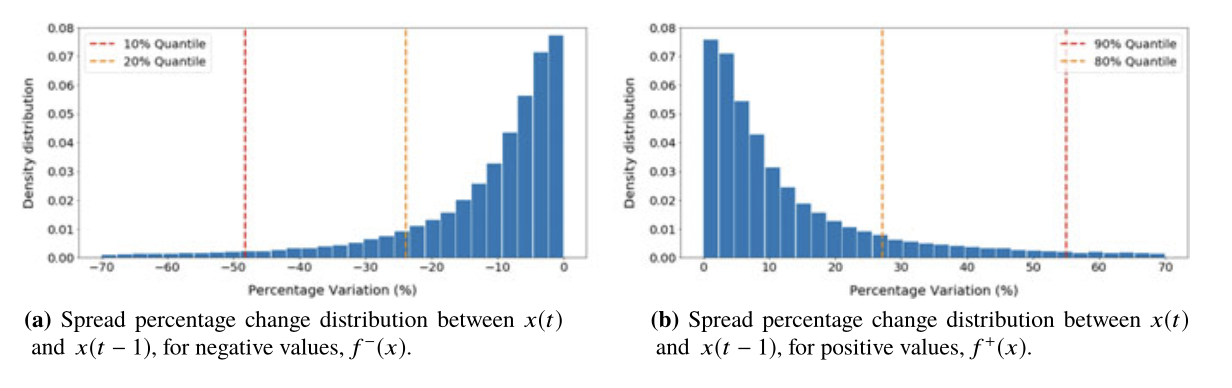

In [1]:
from IPython.display import Image
Image(filename='Quantile_time_series/quantile_thresholds.png')

## Quantile-based trading
In the time series approach, our trading rule can be described as

$$(\hat S_{t+1} - S_{t}) \geq Q_{f_{+}} \Rightarrow OPEN LONG $$ $$ (\hat S_{t+1} - S_{t}) \leq Q_{f_{-}} \Rightarrow OPEN SHORT $$ $$0 \leq \hat S_{t+1} - S_{t} \leq Q_{f_{+}} \Rightarrow HOLDLONG$$ $$Q_{f_{-}} \leq \hat S_{t+1} - S_{t} \leq 0 \Rightarrow HOLDSHORT$$

- OPENLONG/OPENSHORT means opening a new long/short position if none was opened before.
- HOLDLONG/HOLDSHORT means holding long/short positions if one was opened before.
- We should exit a long position if HOLDLONG condition was not satisfied, we should exit a short position if HOLDSHORT condition was not satisfied.

**Note**: we use __90%__ and __5%__ quantiles for top positive and bottom negative quantiles thresholds respectively and 0 value as exit threshold, however, the researcher may decide what are the most optimal parameters based on a specific strategy.

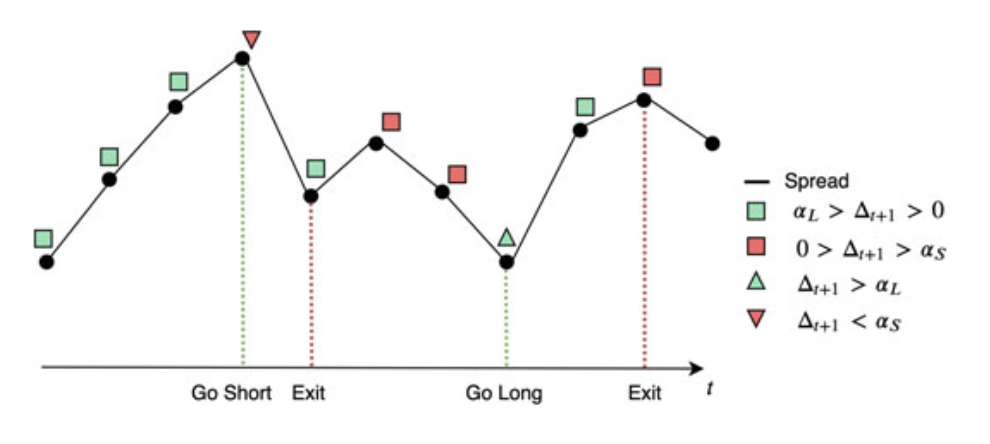

In [2]:
Image(filename='Quantile_time_series/trading_example.png')

## Spread prediction model

In the notebook, we use __Auto ARIMA(p, d, q)__ approach to generate spread predictions. 
Non-seasonal ARIMA models are generally denoted ARIMA(p,d,q) where parameters p, d, and q are non-negative integers, __p__ is the order (number of time lags) of the autoregressive model, __d__ is the degree of differencing (the number of times the data have had past values subtracted), and __q__ is the order of the moving-average model.
In order to choose, best fit ARIMA model parameters we minimize the **Akaike information criterion (AIC)** value: $$AIC = 2k - 2ln(L)$$ where $k$ - number of model parameters and $L$ - likelihood function.

As a part of arbitragelab, we have an Auto ARIMA fit and prediction module which utilizes the **pmdarima** package to find the best model fit.

## Usage of the Algorithms

Let's use the algorithm described above and its performance to Quantile Time Series Strategy. 

- Firstly, we will use the Engle-Granger test to construct a mean-reverting portfolio. 
- Secondly, we will fit the Auto ARIMA model and generate predictions.
- In the third step, we will model spread differences and find trading thresholds.
- Finally, we will generate trading signals using Auto ARIMA and fit thresholds.

In [3]:
import arbitragelab as al
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

### Loading data

Following the example in the Optimal Mean Reversion module, we will use Gold Shares ETF (GLD), Gold Miners ETF (GDX), and Junior Gold Miners ETF (GDXJ) to construct a portfolio of three elements.

In [4]:
# Loading data
train_data =  yf.download("GLD GDX GDXJ", start="2016-01-01", end="2018-01-01")
test_data =  yf.download("GLD GDX GDXJ", start="2018-01-02", end="2019-08-01")

# Taking close prices for chosen instruments
train_three_elements = train_data["Adj Close"][["GLD", "GDX", "GDXJ"]]

test_three_elements = test_data["Adj Close"][["GLD", "GDX", "GDXJ"]]

# Looking at the downloaded data
train_three_elements.head()

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed


,GLD,GDX,GDXJ
Date,,,
2015-12-31,101.459999,13.404492,18.068029
2016-01-04,102.889999,13.765984,18.622953
2016-01-05,103.180000,13.697593,18.660576
2016-01-06,104.669998,13.922304,18.980366
2016-01-07,106.150002,14.537816,19.422426


### Engle-Granger test

In [5]:
# Initialising an object containing needed methods
eg_portfolio = al.cointegration_approach.EngleGrangerPortfolio()

# Fitting the data on a dataset of three elements with constant term
eg_portfolio.fit(train_three_elements, add_constant=True)

# Getting results of the Engle-Granger test
eg_adf_statistics = eg_portfolio.adf_statistics
eg_cointegration_vectors = eg_portfolio.cointegration_vectors

In [6]:
# Looking at the statistic from the last step of the Engle-Granger test
eg_adf_statistics

,0
99%,-3.443418
95%,-2.867303
90%,-2.569840
statistic_value,-3.260982


Using the ADF statistic test output, we can see that our statistic is above the 95% significance level value.

So at a 95% significance level, our elements are cointegrated, we can construct a mean-reverting portfolio using the coefficients from the *eg_cointegration_vectors* variable.

In [7]:
eg_cointegration_vectors

,GLD,GDX,GDXJ
0,1.0,-3.202534,0.951377


As described in the theoretical part, the coefficient for the first element is $1$, while other two are equal to negative regression coefficients.

### Constructing portfolios

In [8]:
# Calculating returns of our elements (ETFs)
train_three_elements_returns = (train_three_elements / train_three_elements.shift(1) - 1)[1:]
test_three_elements_returns = (test_three_elements / test_three_elements.shift(1) - 1)[1:]

train_three_elements_returns.head()

,GLD,GDX,GDXJ
Date,,,
2016-01-04,0.014094,0.026968,0.030713
2016-01-05,0.002819,-0.004968,0.002020
2016-01-06,0.014441,0.016405,0.017137
2016-01-07,0.014140,0.044210,0.023290
2016-01-08,-0.004428,-0.024194,-0.028571


In [9]:
# Also adding weights to take initial prices of our ETFs into account
weights  = train_three_elements.iloc[0] / abs(train_three_elements.iloc[0]).sum()

In [10]:
# Weights of elements for the Engle-Granger portfolio
eg_cointegration_vectors.loc[0]

GLD     1.000000
GDX    -3.202534
GDXJ    0.951377
Name: 0, dtype: float64

In [11]:
# Scaling weights so they sum up to 1
eg_scaled_vectors = eg_cointegration_vectors.loc[0] / abs(eg_cointegration_vectors.loc[0]).sum()

eg_scaled_vectors

GLD     0.194027
GDX    -0.621379
GDXJ    0.184593
Name: 0, dtype: float64

In [12]:
# Calculating portfolio values during the training period
eg_portfolio_returns = (train_three_elements_returns * eg_scaled_vectors * weights).sum(axis=1)
eg_portfolio_price = (eg_portfolio_returns + 1).cumprod()

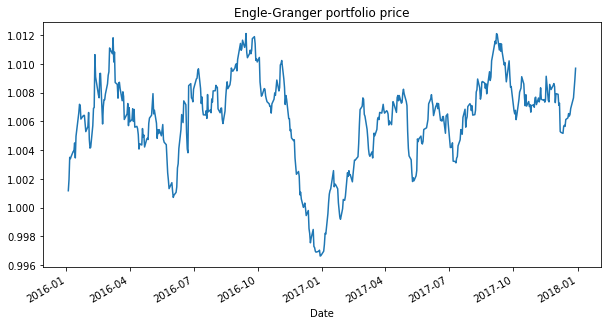

In [13]:
# Plotting Engle-Granger portfolio price
eg_portfolio_price.plot(title='Engle-Granger portfolio price', figsize=(10,5));

### Fit Auto ARIMA model

In [14]:
# Initializing the Auto ARIMA model
arima_model = al.time_series_approach.AutoARIMAForecast(start_p=1, start_q=1, max_p=10, max_q=10)

In [15]:
# Finding the best fitting model without silencing the warnings
arima_model.get_best_arima_model(y_train=eg_portfolio_price, verbose=True, silence_warnings = False)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5777.510, Time=0.15 sec


D:\programs\Anaconda\envs\mlfinlab\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\programs\Anaconda\envs\mlfinlab\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\programs\Anaconda\envs\mlfinlab\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\programs\Anaconda\envs\mlfinlab\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1886: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
D:\programs\Anaconda\envs\mlfinlab\lib\site-packages\statsmodels\tsa\state

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5781.536, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5779.535, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5779.515, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5783.285, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.470 seconds


We can see that we are getting quite a few ConvergenceWarning, so we can assume that the Auto ARIMA method doesn't quite fit to this input data.

There is an option to silence the warning for this particular function by using the _silence_warnings_ flag.

In [16]:
# Finding the best fitting model and silencing the warnings
arima_model.get_best_arima_model(y_train=eg_portfolio_price, verbose=True, silence_warnings = True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5777.510, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5781.536, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5779.535, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5779.515, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5783.285, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.458 seconds


### Get trading thresholds (quantiles)

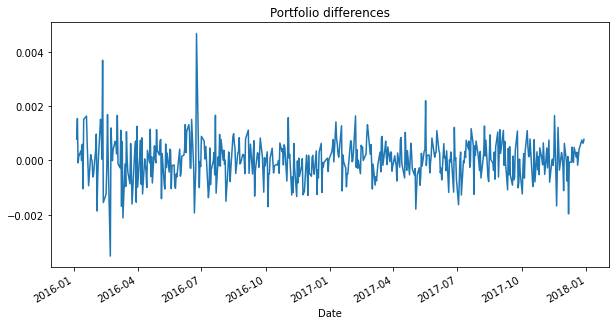

In [17]:
# Plotting portfolio differences
eg_portfolio_price.diff().plot(title='Portfolio differences', figsize=(10,5));

In [18]:
# Init strategy class
time_series_trading = al.time_series_approach.QuantileTimeSeriesTradingStrategy(long_quantile=0.8, short_quantile=0.2)

# Fit portfilio to find Q_{-} and Q_{+}
time_series_trading.fit_thresholds(eg_portfolio_price)

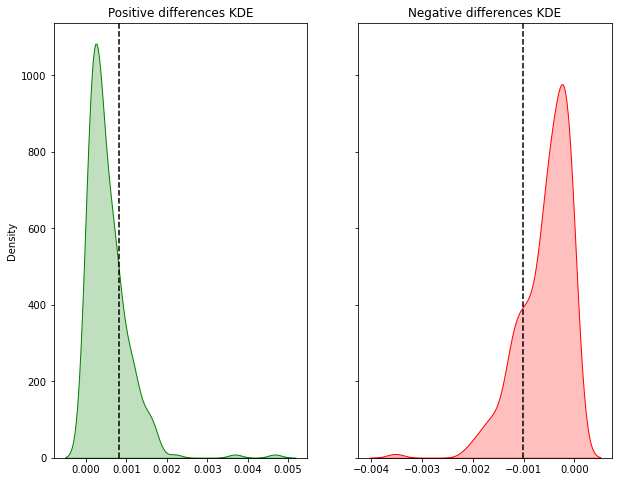

In [19]:
# Plot thresholds used for trading
time_series_trading.plot_thresholds();

### Generate out-of-sample ARIMA predictions

In [20]:
# Creating a test portfolio based on the EG test results
test_three_elements_returns = (test_three_elements / test_three_elements.shift(1) - 1)[1:]

# Also adding weights to take initial prices of ETFs into account
weights  = test_three_elements.iloc[0] / abs(test_three_elements.iloc[0]).sum()

test_portfolio_returns = (test_three_elements_returns * eg_scaled_vectors * weights).sum(axis=1)

test_portfolio_price = (test_portfolio_returns + 1).cumprod()

The progress bar was added to the prediction generation process to check the execution state of the method.

In [21]:
# Generate out-of-sample ARIMA prediction
oos_prediction = arima_model.predict(y=test_portfolio_price, silence_warnings = True)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


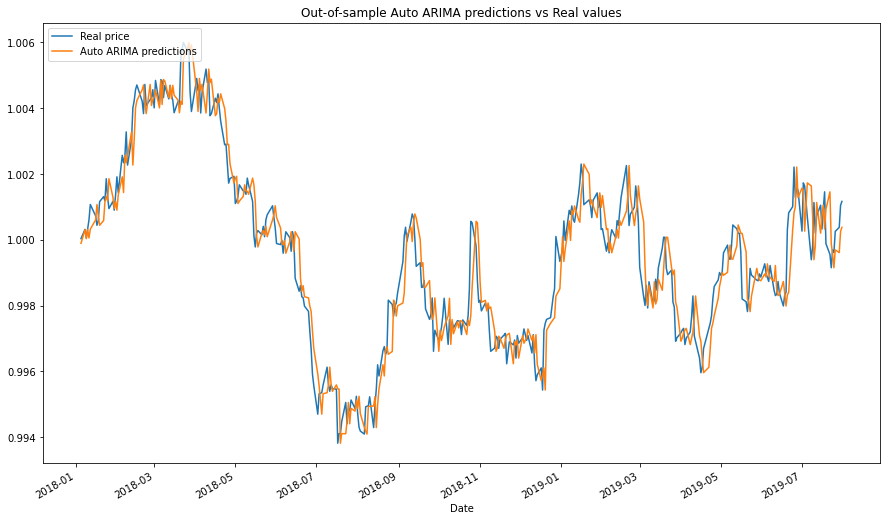

In [22]:
# Compare results
plt.figure(figsize=(12,5))

ax1 = test_portfolio_price[2:].plot(label='Real price', figsize=(10,5))
ax2 = oos_prediction[2:].plot(label ='Auto ARIMA predictions', figsize=(15,9), title='Out-of-sample Auto ARIMA predictions vs Real values')

plt.legend(loc=2)
plt.show()

### Applying Quantile Time Series trading strategy

In [23]:
# Use the difference between prediction and actual value to trade the spread
for prediction, actual in zip(oos_prediction, test_portfolio_price):
    time_series_trading.get_allocation(predicted_difference=prediction-actual, exit_threshold=0)

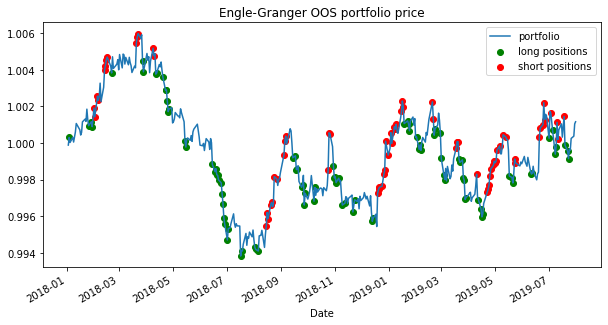

In [24]:
# Plot positions created using a quantile time series strategy
positions = pd.Series(index=test_portfolio_price.index, data=time_series_trading.positions)

# Getting only short and only long positions
long_positions = positions[positions == 1]
short_positions = positions[positions == -1]

# Plottign the positions
test_portfolio_price.plot(title='Engle-Granger OOS portfolio price', figsize=(10,5), label='portfolio')
plt.scatter(long_positions.index, test_portfolio_price.loc[long_positions.index], color='green', label='long positions')
plt.scatter(short_positions.index, test_portfolio_price.loc[short_positions.index], color='red', label='short positions')
plt.legend(loc='best');

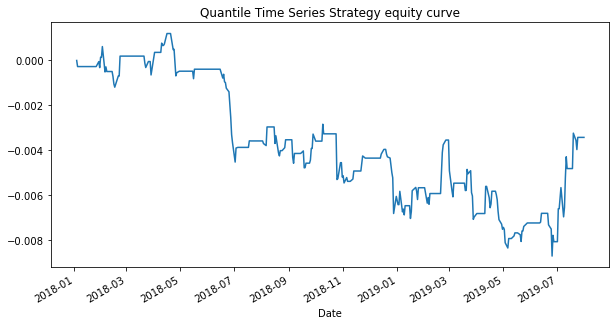

In [25]:
# Generate equity curve
equity_curve = (positions.shift(1) * test_portfolio_price.diff()).cumsum()
equity_curve.plot(title='Quantile Time Series Strategy equity curve', figsize=(10, 5));

As we can see, the strategy generates negative returns due to the bad quality of the ARIMA model prediction. Let's see how the model works if we have a "perfect prediction" - the spread value for the next day.

### Perfect prediction results

In [26]:
# Init strategy class
perfect_series_trading = al.time_series_approach.QuantileTimeSeriesTradingStrategy(long_quantile=0.8, short_quantile=0.2)

# Getting the threshold values
perfect_series_trading.fit_thresholds(eg_portfolio_price)

In [27]:
# Use difference between prediction and actual value to trade the spread
for prediction, actual in zip(test_portfolio_price.shift(-1), test_portfolio_price):
    perfect_series_trading.get_allocation(predicted_difference=prediction-actual, exit_threshold=0)

In [28]:
positions = pd.Series(index=test_portfolio_price.index, data=perfect_series_trading.positions)

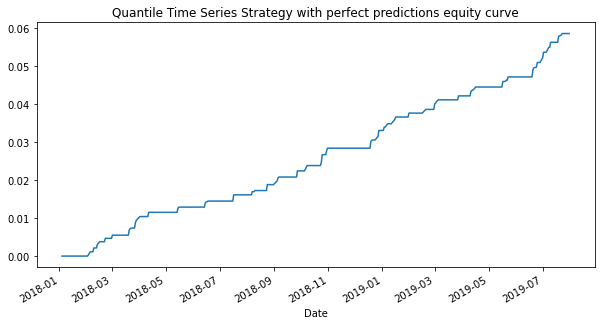

In [29]:
# Generate equity curve for "perfect" prediction.
perfect_equity_curve = (positions.shift(1) * test_portfolio_price.diff()).cumsum()
perfect_equity_curve.plot(title='Quantile Time Series Strategy with perfect predictions equity curve', figsize=(10, 5));

## Conclusion

This notebook describes a new strategy from the Time Series Approach - the Quantile Time Series Strategy. The key part of the strategy is to generate time series prediction and trade when the predicted value deviates from the current spread value. In the notebook, we used the Auto ARIMA as a tool to generate spread value prediction.

The algorithms and the descriptions used in this notebook were described in the book by _Simão Moraes Sarmento_ and _Nuno_ _Horta_ __A Machine Learning based Pairs Trading Investment Strategy__ [available here](https://www.springer.com/gp/book/9783030472504).

Key takeaways from the notebook:
- The strategy is based on the expectation that the investor can benefit from an abrupt movement of the spread value.
- This strategy needs a forecasting algorithm to work, in this case, the Auto ARIMA tool was used.
- The thresholds to enter the positions are defined based on the quantiles of the percentage change distribution during a formation period. 
- For the spread forecasting, non-parametric methods can be used, such as Artificial Neural Networks.